### Workflow:

1. Load 1 dataset for a given stoichiometry
2. Select initial hyperparameters and train, select best model.
3. Load other data for same stoichiometry, transfer model and train
4. Select best model for each velocity
5. Extract data and build linear graphic

### Example.
I will illustrate this workflow for La0.9Ca0.1NO3

In [1]:
#Hide warnings when logging
from tensorflow.compat.v1.logging import set_verbosity,ERROR
set_verbosity(ERROR)

from Utils import *

Using TensorFlow backend.


## 1. Load dataset

In [2]:
name='data/La0.9Ca0.1NiO310C.txt'
df,NormPrms = LoadDF(name)

3446 points dropped
1090 points dropped


## 2. Select initial hyperparameters and train.

#### A folder should be created in order to store the newly created models. The name of this folder must be passed to TrainFirstModels with the variable "name". The program expects it to be located at models/

In [3]:
hyper = array([[-0.55,-0.33,0.36,0.61,0.75,0.61],        #Suggested 's' values
               [0.3,0.3,0.3,0.0003,0.01,0.3],            #Max. deviation of the s values.
               [1,1,1,0,0,1],                            #Orientation of the given curve
               [-6.07,-27.93,-6.93,65.97,45.00,30.34],   #k vals
               [1.04,1.32,0.94,0.88,1.28,-1.09],         #A vals 
               [0,0,0,1,0,0]])                           #freezeS

Training model 0...
Epoch 00336: early stopping


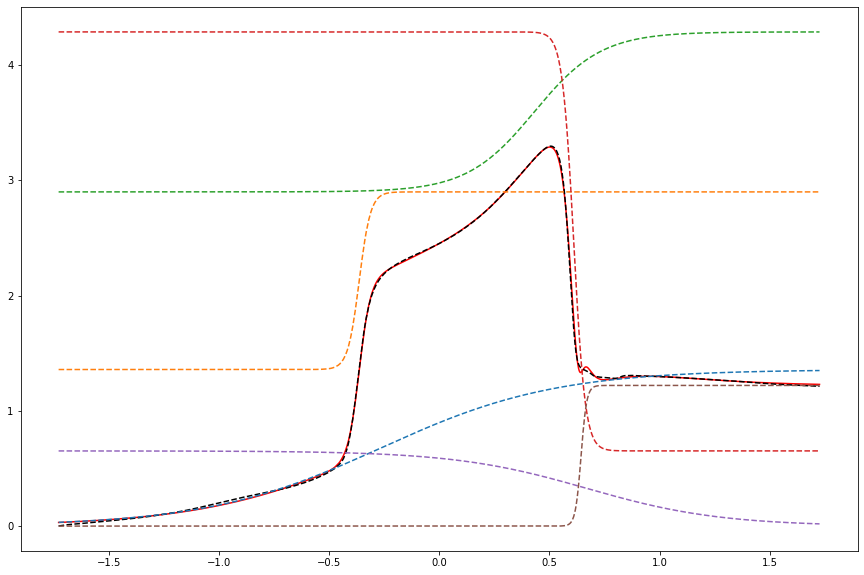

Cost = 0.00020897940461704707
Training model 1...
Epoch 00305: early stopping


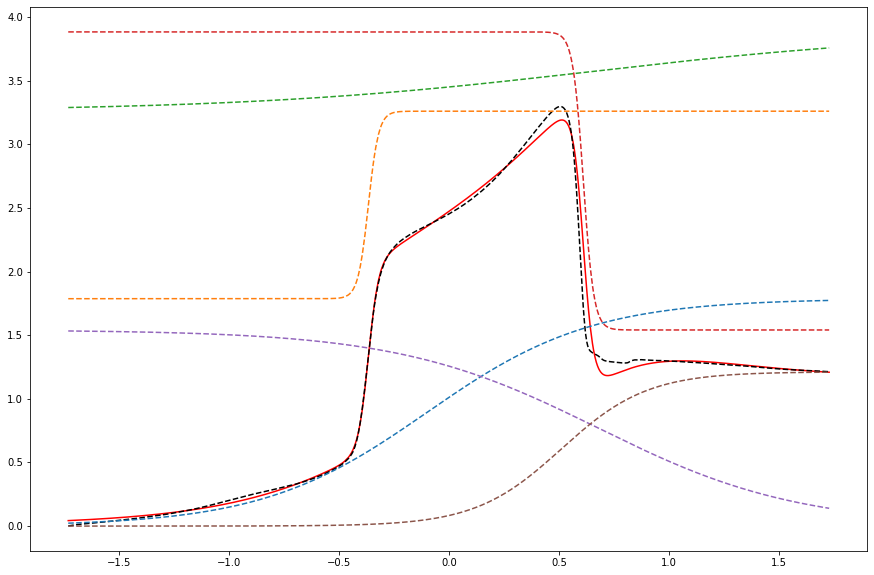

Cost = 0.005893725605512207
Training model 2...
Epoch 00325: early stopping


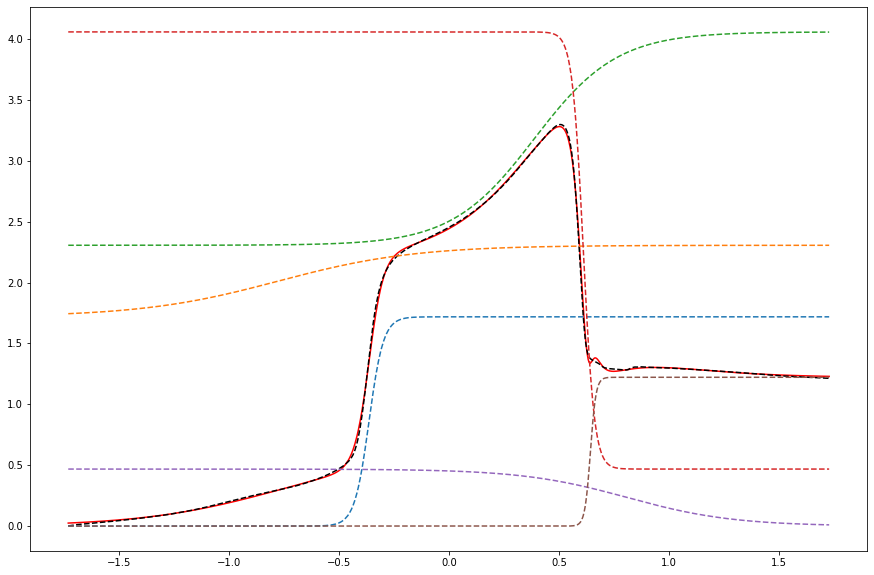

Cost = 0.0002209894146004399
Training model 3...
Epoch 00366: early stopping


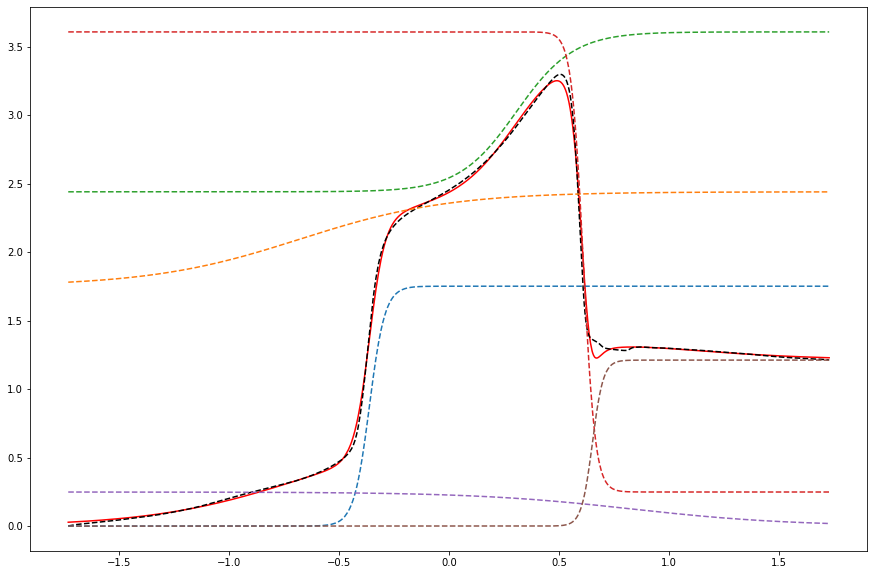

Cost = 0.0011312617779871033
Training model 4...
Epoch 00332: early stopping


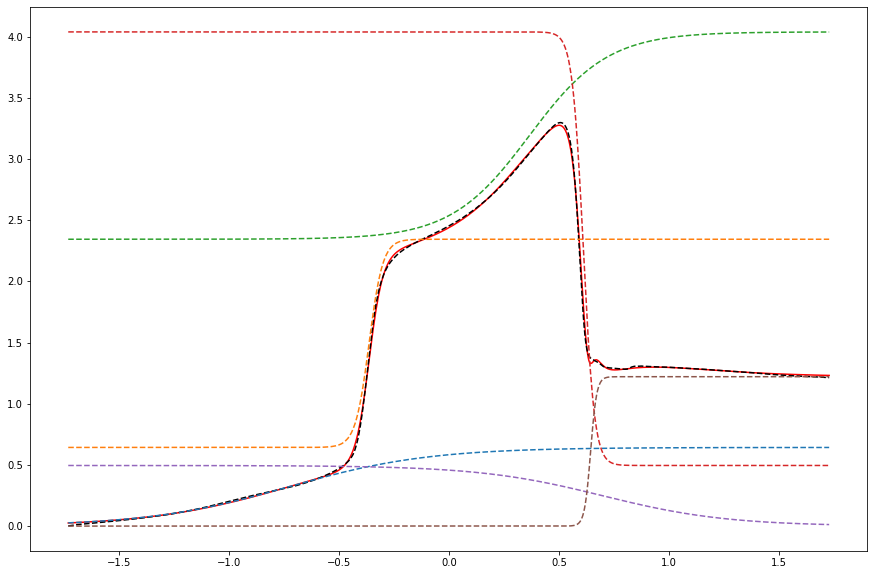

Cost = 0.00026296577199885605


In [5]:
#Set this array according to the description of its entries.
"""Each column corresponds to 1 of the logistic functions
Row1: Set S values: Suggested S values (normalized T)
Row2: "Degrees of freedom" for this S value (how much can it deviate from suggested S)
Row3: Orientation of curve. If 1, gain event. If 0, loss event
Row4: Suggested k values (steepness of curve)
Row5: Suggested A values (relative importance of event, by how much did mass increment with this event?)
Row6: Which S values are to be fixed
"""
#Train N models for data: df with hyperparapeters "hyper"
def TrainFirstModels(df,hyper,name='La0.9',lr=5e-1,epochs=500,N=10,weights=0):
    for i in range(N):
        pk0 = max(df.y)+0.3+rand()*0.7
        print(f"Training model {i}...")
        prms,loss=Optimize(df,hyper,peak=pk0,lr=lr,epochs=epochs,v=0,weights=weights)
        
        #Move new models to new folder and copy losses
        !cp /tmp/W.hdf5 models/{name}/{i}Model_6C.hdf5
        !echo {i} "6" {loss} >> models/{name}/losses6C.dat
        
        plot_wr(df,prms,hyper)
        print(f"Cost = {loss}")
        
TrainFirstModels(df,hyper,name='La0.9',lr=5e-1,epochs=500,N=5)

#### Selection must be done manually by looking at produced graphics.

Once selection is done, you will have to load this one model and construct a hyper array from it, so it can be transferred to the other datasets.

#### In this case I select Model 0. It has minimum error and curves seem to make sense.  
#### It was stored as models/La0.9/0Model_6C.hdf5

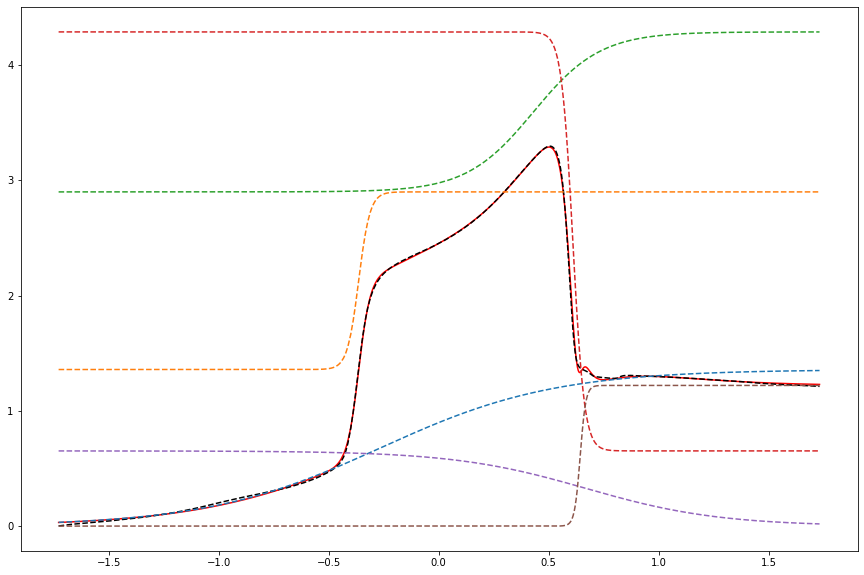

In [4]:
initialModel = 'models/La0.9/0Model_6C.hdf5'
prms = LoadModel(initialModel,hyper)
hyper = BuildHyperFromModel(prms,hyper)

plot_wr(df,prms,hyper)

## 3.a. Load other data for same stoichiometry and transfer model.

In [5]:
stoichiom = 'La0.9'
#Load all data for this stoichiometry
names = !ls data/{stoichiom}*txt
dfs = {}
for name in names:
    df,NormPrms = LoadDF(name)            #Load data
    DFiHyper = TransferHyper(df,hyper)    #Transfer model
    dfs[name] = (df,DFiHyper,NormPrms)
    print(f"{name} successfully loaded.")

3530 points dropped
1127 points dropped
data/La0.9Ca0.1NiO310C.txt successfully loaded.
2622 points dropped
835 points dropped
data/La0.9Ca0.1NiO315C.txt successfully loaded.
3986 points dropped
1212 points dropped
data/La0.9Ca0.1NiO35C.txt successfully loaded.
4010 points dropped
1217 points dropped
data/La0.9Ca0.1NiO38C.txt successfully loaded.


## 3.b. Train each model.

Training for La0.9Ca0.1NiO310C.txt...
	Training for peak + 0.4...
Epoch 00261: early stopping
Loss = 0.00026104204476694526


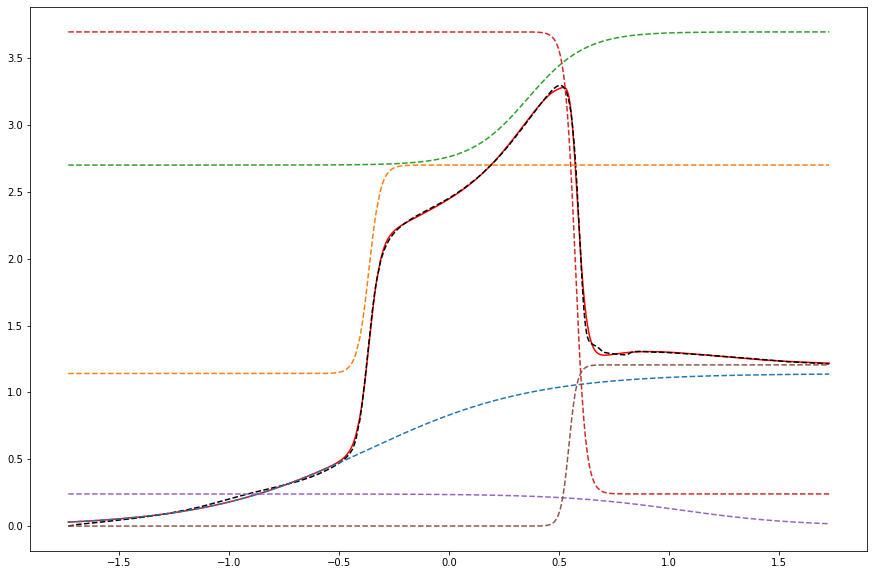

	Training for peak + 1.0...
Epoch 00244: early stopping
Loss = 0.00012569386133089825


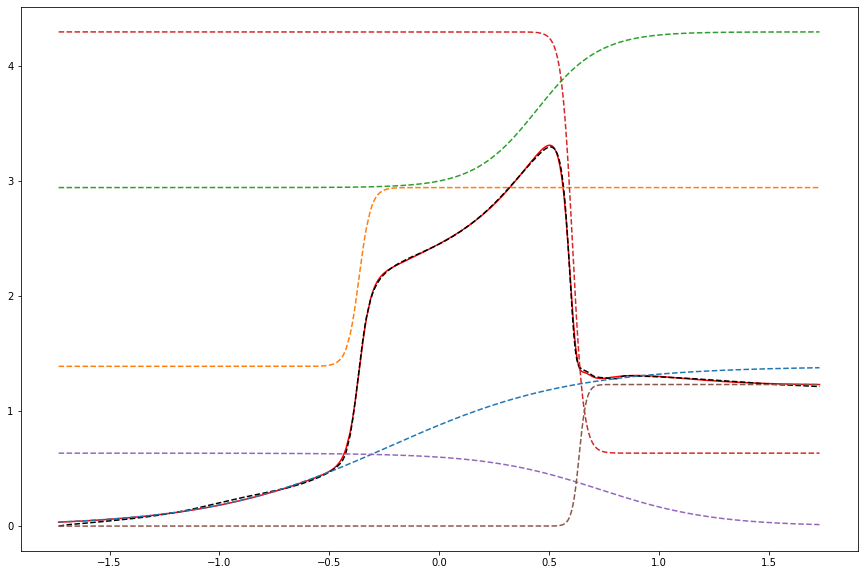

Training for La0.9Ca0.1NiO315C.txt...
	Training for peak + 0.4...
Epoch 00224: early stopping
Loss = 0.0002352525487383381


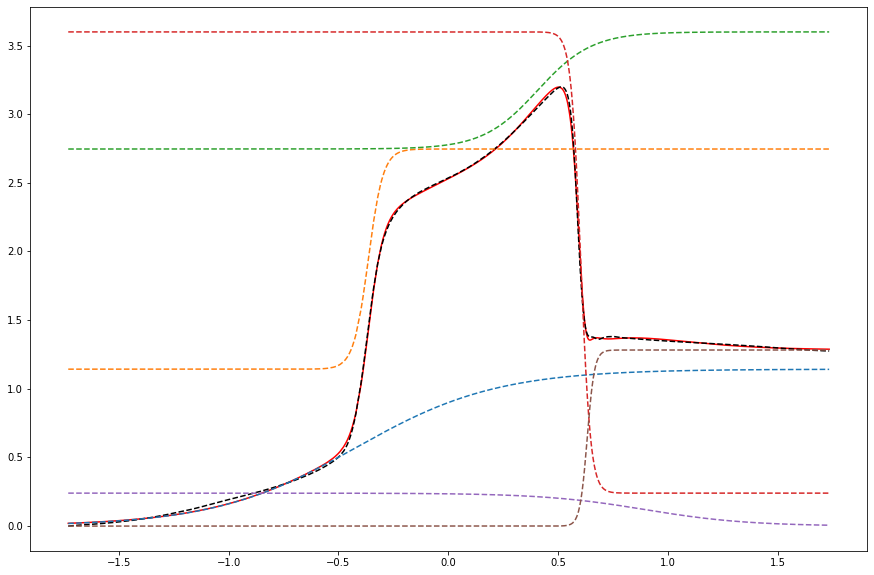

	Training for peak + 1.0...
Epoch 00285: early stopping
Loss = 0.00034630282883215817


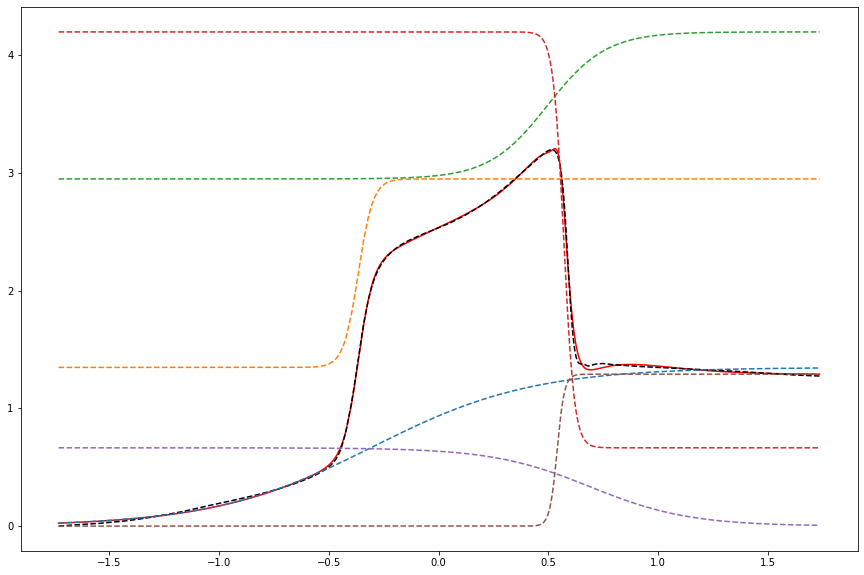

Training for La0.9Ca0.1NiO35C.txt...
	Training for peak + 0.4...
Epoch 00239: early stopping
Loss = 0.0002170943503928721


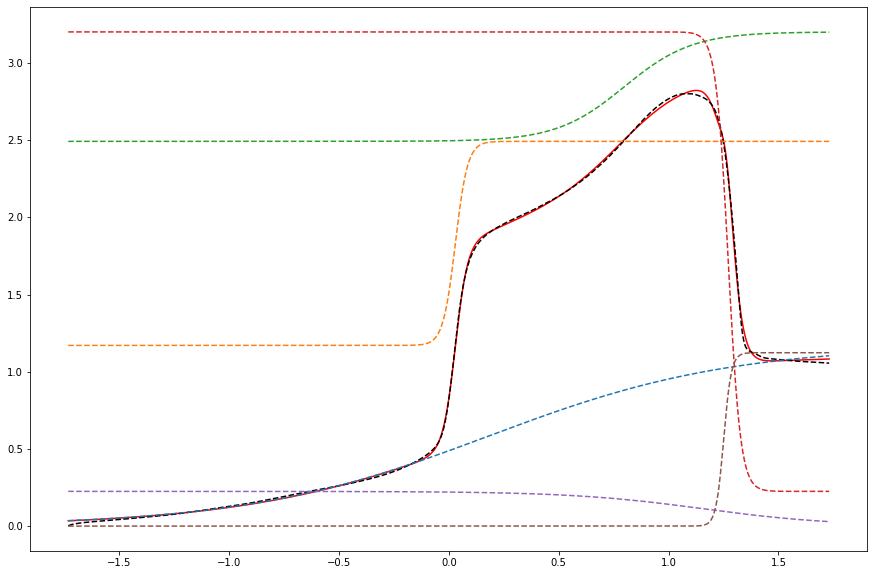

	Training for peak + 1.0...
Epoch 00297: early stopping
Loss = 0.000376039102596787


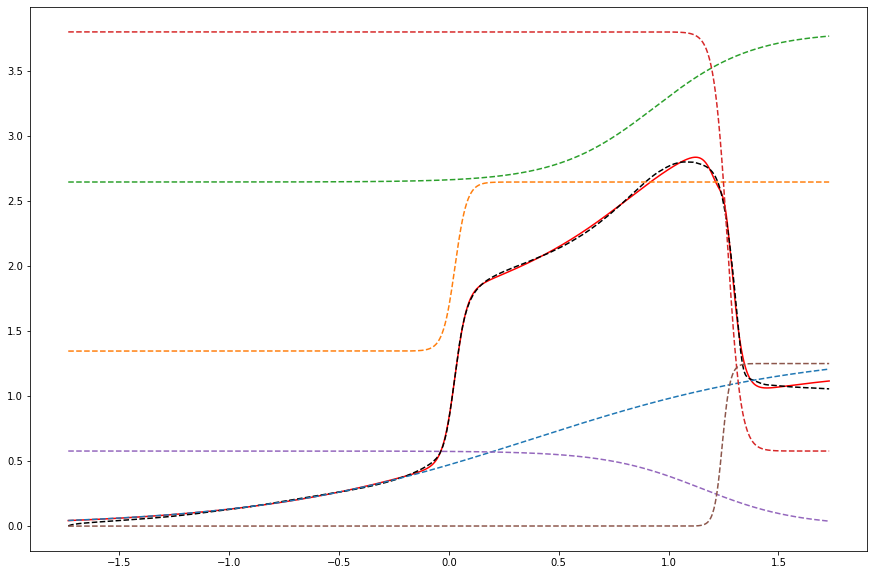

Training for La0.9Ca0.1NiO38C.txt...
	Training for peak + 0.4...
Epoch 00238: early stopping
Loss = 0.00021598884638253634


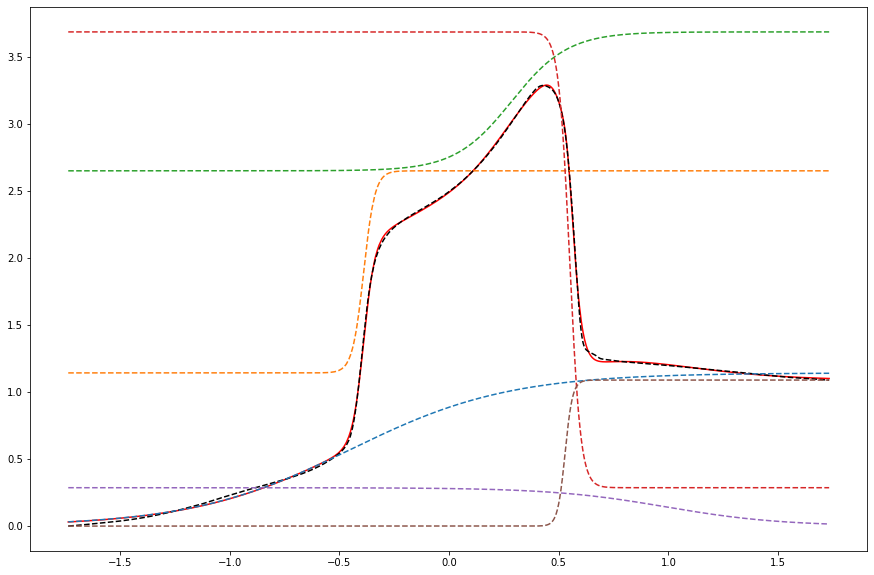

	Training for peak + 1.0...
Epoch 00260: early stopping
Loss = 0.0002496017892887696


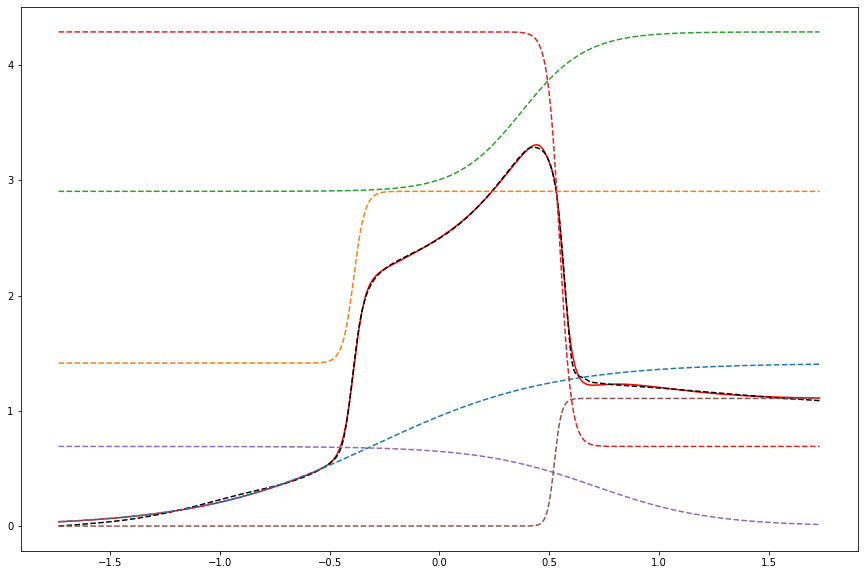

In [11]:
#!mkdir models/TransferLa0.9
for name in names:
    df,hyper,normPrs = dfs[name]
    #Give more freedom to first and second loss events
    hyper[1,3] = 0.3
    hyper[1,4] = 0.3
    #Unfreeze all variables
    hyper[5,:] = 0.0 
    name = name.split('/')[-1]
    print(f"Training for {name}...")
    
    #For each DS train 2 different models with different peak heights
    for i in range(2):
        print(f"\tTraining for peak + {0.4 + 0.6*i}...")
        pk0 = max(df.y) + 0.4 + 0.6*i
        prms,loss=Optimize(df,hyper,peak=pk0,lr=5e-2,epochs=500,v=0)
  
        #Move new models to new folder and copy losses
        !cp /tmp/W.hdf5 models/TransferLa0.9/{name}_M{i}_6C.hdf5
        !echo {i} "6" {loss} >> models/TransferLa0.9/losses6C.dat
        print(f"Loss = {loss}")
        plot_wr(df,prms,hyper)

## 4. Selection must be done by manually moving selected models to a given folder.
#### This program expects the models to be used to be in the folder models/Finals/

In [6]:
#Load all trained models:
PRMS = {}
for name in names:
    name = name.split('/')[-1]
    if name[:5]=='La0.9':
        file=!ls models/Finals/{name}*M0*
        PRMS[name] = LoadModel(file[0],hyper)

## 5. Extract data and build the linear model

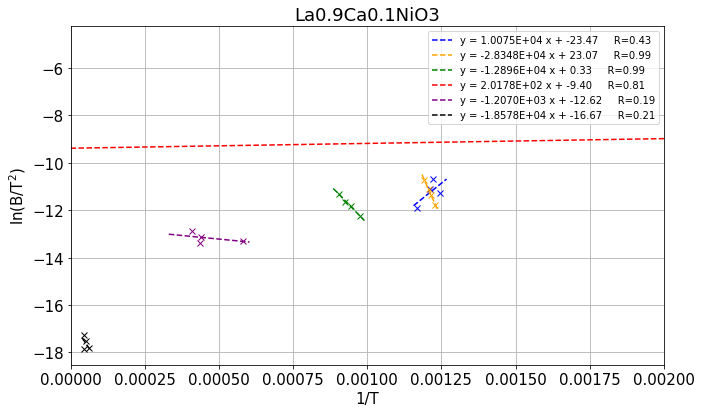

In [8]:
#Build dicts containing extracted and transformed data
steqs = ['0.9']
X,Y = FeatureDict(PRMS,names,dfs,steqs=steqs,exponent = 2)

#All the dicts have been constructed. Now plot the data and make regression 
PlotLinearModels(X,Y,xlims=[0,0.002])